=== Финальное обучение модели ===

1. Загрузка данных...
✅ Сэмпл данных загружен: (152842, 21)

Распределение целевой переменной:
target
1    102842
0     50000
Name: count, dtype: int64
Conversion rate: 0.6729

2. Подготовка фич...
Категориальные фичи (8): ['utm_source_type', 'utm_medium', 'device_category', 'os_type', 'device_browser', 'time_of_day', 'event_category_group', 'country_region']
Числовые фичи (12): ['day_of_week', 'hour_of_day', 'hour_sin', 'hour_cos', 'is_weekend', 'month', 'is_peak_hours', 'session_hits_count', 'unique_event_categories', 'unique_event_actions', 'unique_pages', 'is_returning_user']
  Закодирована колонка: utm_source_type
  Закодирована колонка: utm_medium
  Закодирована колонка: device_category
  Закодирована колонка: os_type
  Закодирована колонка: device_browser
  Закодирована колонка: time_of_day
  Закодирована колонка: event_category_group
  Закодирована колонка: country_region
Финальный размер данных: (152842, 20)

3. Разделение на train/test...
Tr

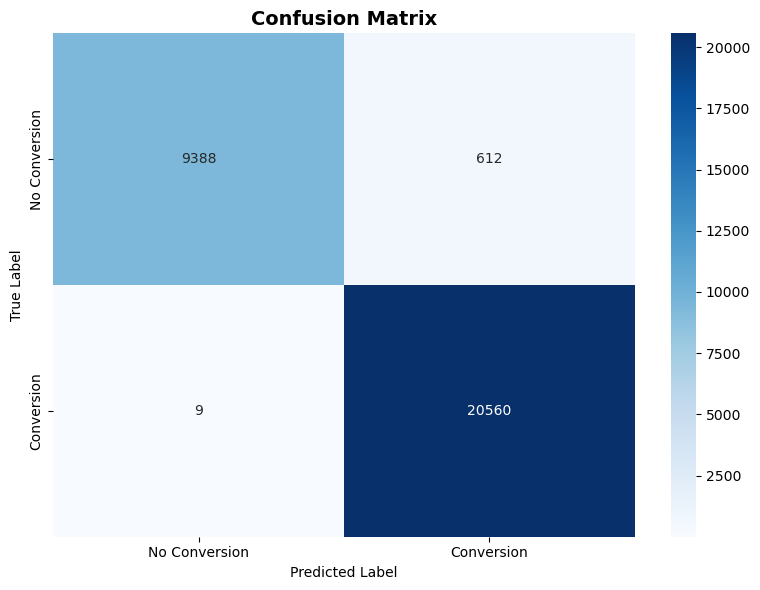


📋 Classification Report:
               precision    recall  f1-score   support

No Conversion       1.00      0.94      0.97     10000
   Conversion       0.97      1.00      0.99     20569

     accuracy                           0.98     30569
    macro avg       0.99      0.97      0.98     30569
 weighted avg       0.98      0.98      0.98     30569


7. Анализ важности фич...
Топ-15 самых важных фич:
                         feature  importance
18  event_category_group_encoded    0.870650
9           unique_event_actions    0.030739
8        unique_event_categories    0.028107
10                  unique_pages    0.018795
7             session_hits_count    0.016223
11             is_returning_user    0.009761
13            utm_medium_encoded    0.004367
5                          month    0.004186
15               os_type_encoded    0.003104
16        device_browser_encoded    0.002199
1                    hour_of_day    0.001944
3                       hour_cos    0.001893
12  

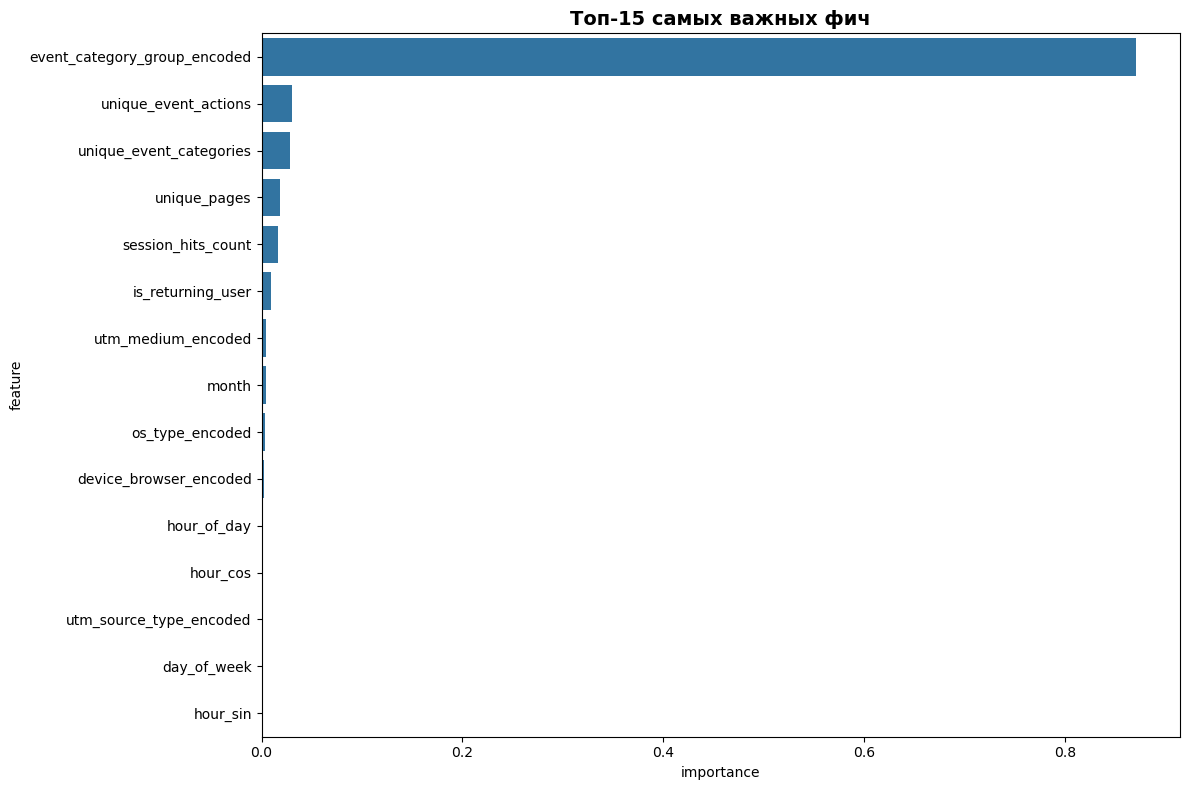


8. Анализ оптимального порога...
Оптимальный порог: 0.505
F1-Score при оптимальном пороге: 0.9852

9. Сохранение модели и артефактов...
✅ Модель и артефакты сохранены

10. Создание примера для API...
🧪 Тестовое предсказание:
  ❌ Ошибка: y contains previously unseen labels: 'unknown'
  Доступные фичи в модели: ['day_of_week', 'hour_of_day', 'hour_sin', 'hour_cos', 'is_weekend', 'month', 'is_peak_hours', 'session_hits_count', 'unique_event_categories', 'unique_event_actions', 'unique_pages', 'is_returning_user', 'utm_source_type_encoded', 'utm_medium_encoded', 'device_category_encoded', 'os_type_encoded', 'device_browser_encoded', 'time_of_day_encoded', 'event_category_group_encoded', 'country_region_encoded']

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ
📊 ДАННЫЕ:
   • Размер данных: (152842, 21)
   • Train set: (122273, 20)
   • Test set: (30569, 20)

🎯 РЕЗУЛЬТАТЫ МОДЕЛИ:
   • ROC-AUC: 0.9902
   • F1-Score: 0.9851
   • Precision: 0.9711
   • Recall: 0.9996

⚙️  РЕКОМЕНДАЦИИ:
   • Оптимальный 

10206

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_curve)
import warnings
import joblib
import os
import gc

warnings.filterwarnings('ignore')

print("=== Финальное обучение модели ===\n")

# 1. Загрузка данных
print("1. Загрузка данных...")

try:
    # Используем сэмпл для быстрого обучения
    data = pd.read_csv('model_data_sample.csv')
    print(f"✅ Сэмпл данных загружен: {data.shape}")
except FileNotFoundError:
    try:
        data = pd.read_csv('model_data_final.csv')
        print(f"✅ Полные данные загружены: {data.shape}")
        
        # Сэмплируем для скорости
        if len(data) > 100000:
            data = data.sample(n=100000, random_state=42)
            print(f"✅ Взят сэмпл: {data.shape}")
            
    except FileNotFoundError:
        print("❌ Файлы данных не найдены")
        raise

# Проверка целевой переменной
print(f"\nРаспределение целевой переменной:")
target_stats = data['target'].value_counts()
print(target_stats)
print(f"Conversion rate: {data['target'].mean():.4f}")

# 2. Подготовка фич
print("\n2. Подготовка фич...")

X = data.drop('target', axis=1)
y = data['target']

# Разделяем категориальные и числовые фичи
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Категориальные фичи ({len(categorical_columns)}): {categorical_columns}")
print(f"Числовые фичи ({len(numerical_columns)}): {numerical_columns}")

# Label Encoding для категориальных фич
label_encoders = {}
X_encoded = X.copy()

for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col + '_encoded'] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"  Закодирована колонка: {col}")

# Удаляем оригинальные категориальные колонки
X_final = X_encoded.drop(categorical_columns, axis=1)

print(f"Финальный размер данных: {X_final.shape}")

# 3. Разделение на train/test
print("\n3. Разделение на train/test...")

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train CR: {y_train.mean():.4f}")
print(f"Test CR: {y_test.mean():.4f}")

# 4. Обучение модели
print("\n4. Обучение RandomForest...")

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("🔄 Обучение модели...")
model.fit(X_train, y_train)
print("✅ Модель обучена")

# 5. Оценка модели
print("\n5. Оценка модели...")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Основные метрики
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 ОСНОВНЫЕ МЕТРИКИ:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 6. Детальная оценка
print("\n6. Детальная оценка...")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('plots/confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Conversion', 'Conversion']))

# 7. Анализ важности фич
print("\n7. Анализ важности фич...")

feature_importance = pd.DataFrame({
    'feature': X_final.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-15 самых важных фич:")
print(feature_importance.head(15))

# Визуализация
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Топ-15 самых важных фич', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/feature_importance_final.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Анализ порогов
print("\n8. Анализ оптимального порога...")

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals)
f1_scores = np.nan_to_num(f1_scores)

# Ищем оптимальный порог (исключаем последний элемент)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold:.3f}")
print(f"F1-Score при оптимальном пороге: {optimal_f1:.4f}")

# 9. Сохранение модели
print("\n9. Сохранение модели и артефактов...")

os.makedirs('models', exist_ok=True)

# Сохраняем модель
joblib.dump(model, 'models/conversion_model.pkl')

# Сохраняем label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')

# Сохраняем информацию о фичах
feature_info = {
    'feature_columns': X_final.columns.tolist(),
    'categorical_columns': categorical_columns,
    'numerical_columns': numerical_columns,
    'optimal_threshold': optimal_threshold
}
joblib.dump(feature_info, 'models/feature_info.pkl')

print("✅ Модель и артефакты сохранены")

# 10. Создание примера для API
print("\n10. Создание примера для API...")

def predict_conversion_example(features_dict):
    """Пример функции для предсказания"""
    try:
        # Создаем DataFrame из входных данных
        input_data = pd.DataFrame([features_dict])
        
        # Применяем Label Encoding
        for col, encoder in label_encoders.items():
            if col in input_data.columns:
                input_data[col] = input_data[col].astype(str)
                known_categories = set(encoder.classes_)
                input_data[col] = input_data[col].apply(
                    lambda x: x if x in known_categories else 'unknown'
                )
                input_data[col + '_encoded'] = encoder.transform(input_data[col])
        
        # Подготавливаем фичи - используем только те, которые есть в feature_info
        available_columns = [col for col in feature_info['feature_columns'] if col in input_data.columns]
        X_input = input_data[available_columns]
        
        # Проверяем, что все нужные фичи присутствуют
        missing_columns = set(feature_info['feature_columns']) - set(available_columns)
        if missing_columns:
            return {
                'error': f'Отсутствуют фичи: {missing_columns}',
                'success': False
            }
        
        # Предсказание
        prediction_proba = model.predict_proba(X_input)[0]
        conversion_prob = prediction_proba[1]
        prediction = 1 if conversion_prob >= optimal_threshold else 0
        
        return {
            'conversion_prediction': prediction,
            'conversion_probability': conversion_prob,
            'no_conversion_probability': prediction_proba[0],
            'threshold_used': optimal_threshold,
            'success': True
        }
    except Exception as e:
        return {
            'error': str(e),
            'success': False
        }

# Тестовый пример - используем правильные названия колонок
test_example = {
    'utm_source_type': 'social',
    'utm_medium': 'cpc', 
    'device_category': 'mobile',
    'os_type': 'Android',
    'device_browser': 'Chrome',
    'day_of_week': 2,
    'hour_of_day': 14,
    'hour_sin': 0.0,
    'hour_cos': 1.0,
    'time_of_day': 'afternoon',
    'is_weekend': 0,
    'month': 6,
    'is_peak_hours': 1,
    'session_hits_count': 15,
    'unique_event_categories': 5,
    'unique_event_actions': 8,
    'unique_pages': 10,
    'is_returning_user': 0,
    'event_category_group': 'engagement_click',
    'country_region': 'cis'
}

result = predict_conversion_example(test_example)
print("🧪 Тестовое предсказание:")

if result.get('success', False):
    print(f"  Конверсия: {'ДА' if result['conversion_prediction'] else 'НЕТ'}")
    print(f"  Вероятность конверсии: {result['conversion_probability']:.4f}")
    print(f"  Порог: {result['threshold_used']:.3f}")
else:
    print(f"  ❌ Ошибка: {result.get('error', 'Unknown error')}")
    print(f"  Доступные фичи в модели: {feature_info['feature_columns']}")

# 11. Финальная сводка
print("\n" + "="*60)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ")
print("="*60)

print(f"📊 ДАННЫЕ:")
print(f"   • Размер данных: {data.shape}")
print(f"   • Train set: {X_train.shape}")
print(f"   • Test set: {X_test.shape}")

print(f"\n🎯 РЕЗУЛЬТАТЫ МОДЕЛИ:")
print(f"   • ROC-AUC: {roc_auc:.4f}")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")

print(f"\n⚙️  РЕКОМЕНДАЦИИ:")
print(f"   • Оптимальный порог: {optimal_threshold:.3f}")
print(f"   • F1 с оптимальным порогом: {optimal_f1:.4f}")

print(f"\n💾 СОХРАНЕННЫЕ ФАЙЛЫ:")
print(f"   • models/conversion_model.pkl - финальная модель")
print(f"   • models/label_encoders.pkl - кодировщики")
print(f"   • models/feature_info.pkl - информация о фичах")
print(f"   • plots/confusion_matrix_final.png - матрица ошибок")
print(f"   • plots/feature_importance_final.png - важность фич")

print(f"\n✅ ОБУЧЕНИЕ МОДЕЛИ УСПЕШНО ЗАВЕРШЕНО!")
print("="*60)

# Освобождаем память
del data, X_train, X_test, y_train, y_test
gc.collect()